In [1]:
from utils import get_un_data, agg_df, move_legend

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


c:\python38\lib\site-packages\pandasdmx\remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


### Download data

In [2]:
elec_df = get_un_data(dataflow = 'DF_UNDATA_ENERGY',
                        structure = 'DSD_ENERGY',
                        commod = 'CL_COMMODITY_NRG',
                        country = 'CL_AREA_NRG',
                        transaction = 'CL_TRANSACTION_NRG',
                        key = {'COMMODITY': '7000'},
                        start_period = '2018')

bal_df = get_un_data(dataflow = 'DF_UNData_EnergyBalance',
                        structure = 'DSD_ENERGY_BALANCE_UNDATA',
                        commod = 'CL_COMMODITY_ENERGY_BALANCE_UNDATA',
                        country = 'CL_AREA',
                        transaction = 'CL_TRANS_ENERGY_BALANCE_UNDATA',
                        key = {'TRANSACTION': ['B11_08811','B12_08821']},
                        start_period = '2018')

all_df = get_un_data(dataflow = 'DF_UNDATA_ENERGY',
                        structure = 'DSD_ENERGY',
                        commod = 'CL_COMMODITY_NRG',
                        country = 'CL_AREA_NRG',
                        transaction = 'CL_TRANSACTION_NRG',
                        key = {'TRANSACTION': ['121','122','1231','1232','1234','1235']},
                        start_period = '2008')

# sum over all countries
elec_df_agg = agg_df(elec_df).reset_index()
bal_df_agg = agg_df(bal_df).reset_index()
all_df_agg = agg_df(all_df).reset_index()


### Question 1: 2018 world electricity generation by source
I left the output as a table, because I think it's easier to read than a pie chart.

In [3]:
# compute electricity production by source
# in the main U.N. database, combustible fuels are not split out
# into gas, coal, etc.

prod_dict = {'Production from combustible fuels – Main activity':'Combustible fuels',
             'Production from Geothermal – Main activity':'Other',
             'Production from chemical heat/sources – Main activity':'Other',
             'Production from Hydro – Main activity':'Hydro',
             'Production from Nuclear – Main activity':'Nuclear',
             'Production from other sources – Main activity':'Other',
             'Production from Solar – Main activity':'Solar',
             'Production from Tide, wave and marine – Main activity':'Other',
             'Production from Wind – Main activity':'Wind',
}

prod_data = elec_df_agg.query('trans_name in @prod_dict.keys()')
prod_data = prod_data.query('TIME_PERIOD == "2018"')
prod_data.rename(columns={'trans_name':'source'}, inplace=True)
prod_data['source'] = prod_data['source'].replace(prod_dict)

prod_data = prod_data[['source', 'value']].groupby('source').sum().reset_index()
prod_data['pct'] = prod_data['value']/prod_data['value'].sum()
prod_data = prod_data.sort_values(by='pct', ascending=False)
prod_data[['source', 'pct']]

,source,pct
0,Combustible fuels,0.643679
1,Hydro,0.173165
2,Nuclear,0.110827
5,Wind,0.050719
4,Solar,0.017821
3,Other,0.003789


In [4]:
# use the energy balance data to split out combustible fuels
# this dataset has the fuel usage expressed in units of energy

bal_dict = {'Biofuels and waste':'Biofuels',
             'Coal and peat products':'Coal',
             'Natural Gas':'Natural Gas',
             'Oil Products':'Oil',
             'Primary Oil':'Oil',
             'Primary coal and peat':'Coal',
}

bal_data = bal_df_agg.query('TIME_PERIOD == "2018"')
bal_data.rename(columns={'Commodity ENERGY Balance Codelist':'source'}, inplace=True)
bal_data = bal_data.query('source in @bal_dict.keys()')
bal_data['source'] = bal_data['source'].replace(bal_dict)

bal_data = bal_data.groupby('source').sum().reset_index()
bal_data['pct'] = bal_data['value']/bal_data['value'].sum()

# multiply pct by combustible fuels' share of generation
comb_share = prod_data.query('source == "Combustible fuels"')['pct'].values[0]
bal_data['pct'] = bal_data['pct'] * comb_share

# combine combustible fuel sources with the rest
source_data = pd.concat([bal_data, prod_data])
source_data = source_data.query('source != "Combustible fuels"')
source_data = source_data.sort_values(by='pct', ascending=False)
source_data[['source','pct']]

,source,pct
1,Coal,0.383287
2,Natural Gas,0.199988
1,Hydro,0.173165
2,Nuclear,0.110827
5,Wind,0.050719
3,Oil,0.031762
0,Biofuels,0.028643
4,Solar,0.017821
3,Other,0.003789


### Question 2: World energy consumption by sector
Note: In the chart, units for different energy sources are not the same (metric tons for coal, kWh for electricity, etc.). So the units are not meaningful, but the trend over time is. Also, electricity from combustible fuels is likely double-counted.

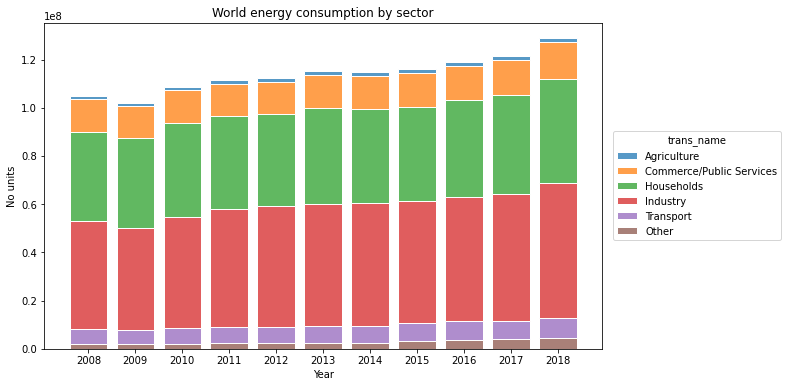

In [9]:
usage_dict = {'Consumption by manufacturing, construction and non-fuel industry':'Industry',
                'Consumption by transport':'Transport',
                'Consumption by agriculture, forestry and fishing':'Agriculture',
                'Consumption by commerce and public services':'Commerce/Public Services',
                'Consumption by households':'Households',
                'Consumption not elsewhere specified (other)':'Other',
                }

usage_years = [str(yr) for yr in range(2008,2019)]

usage_data = all_df_agg.query('trans_name in @usage_dict.keys()')
usage_data = usage_data.query('TIME_PERIOD in @usage_years')
usage_data = usage_data[['TIME_PERIOD', 'trans_name', 'value']]
usage_data = usage_data.groupby(['TIME_PERIOD','trans_name']).sum().reset_index()
usage_data['trans_name'] = usage_data['trans_name'].replace(usage_dict)

plt.figure(figsize=(10,6))

# https://www.pythoncharts.com/python/stacked-bar-charts/
g = sns.histplot(
    usage_data,
    x='TIME_PERIOD',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='value',
    hue='trans_name',
    multiple='stack',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8,
)

g.set_title('World energy consumption by sector')
g.set_xlabel('Year')
g.set_ylabel('No units')
move_legend(g, 'center right', bbox_to_anchor=(1.33, 0.5), ncol=1)
